# Find unbound states to pair with the bound states

### Imports

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/crispy_shifty/projects/OPS/round_1/design
running on node: sofia


### Fix the paths
Necessary because we copied these designs from perlmutter

In [2]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import fix_path_prefixes

folded = "/home/broerman/crispy_shifty/projects/OPS/round_1/design/06_fold_bound_states/folded_states.list"
new_folded = fix_path_prefixes(
    find="/pscratch/sd/b/broerman",
    replace="/home/broerman/crispy_shifty/projects/OPS/round_1/design",
    file=folded,
    overwrite=True,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Pair the designed bound states

In [3]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "07_pair_bound_states"
design_list_file = "/home/broerman/crispy_shifty/projects/OPS/round_1/design/06_fold_bound_states/folded_states.list"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
        "indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    ]
)

extra_kwargs = {
    "reference_csv": "/home/broerman/crispy_shifty/projects/OPS/round_1/design/02_make_free_states/free_state_0s.csv",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.states.pair_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="3G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-2349 /home/broerman/crispy_shifty/projects/OPS/round_1/design/07_pair_bound_states/run.sh


### Collect scorefiles of the paired bound states and concatenate

In [4]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "07_pair_bound_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [6]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

simulation_name = "07_pair_bound_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/2349 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [7]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [8]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [term for term in scores_df.columns if term not in beta_nov16_terms]
]
print(len(scores_df))

2349


In [9]:
print(list(scores_df.columns))

['bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fixed_resis', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'recycles', 'repeat_len', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score', 'score_per_res', 'score_per_res_parent', 'score_per_res_x', 'seed', 'shift', 'ss_sc', 'state', 'time', 'tol', 'topo', 'total_length', 'total_score', 'trim_n', 'trimmed_l

In [27]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

to_plot = [
    "bb_clash_delta_x",
    "score_per_res_x",
    # "wnm_all_x",
]
print(to_plot)

['bb_clash_delta_x', 'score_per_res_x']


### Filter extreme outliers and change some dtypes

In [28]:
scores_df["bb_clash_delta_x"] = scores_df["bb_clash_delta_x"].astype(float)
scores_df["score_per_res_x"] = scores_df["score_per_res_x"].astype(float)
# scores_df["wnm_all_x"] = scores_df["wnm_all_x"].astype(float)


# query = "bb_clash_delta_x < 500 and score_per_res_x < 0"# and wnm_all_x < 5"
# sample_df = scores_df.query(query)
sample_df = scores_df

### Plot loop scores

2it [00:00, 38.09it/s]


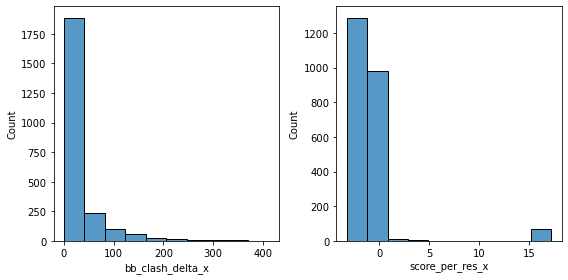

In [29]:
cols = [
    "bb_clash_delta_x",
    "score_per_res_x",
    # "wnm_all_x",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    # hue="parent",
)
plt.savefig(os.path.join(output_path, "loop_scores.png"))

<Figure size 576x576 with 0 Axes>

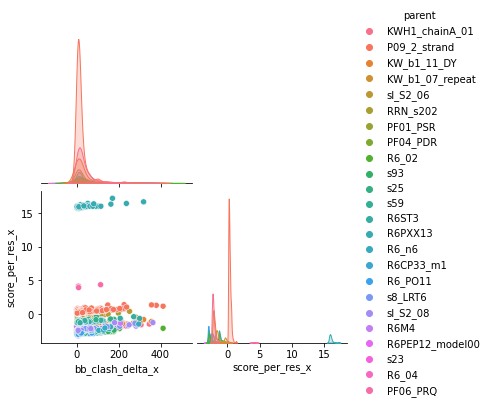

In [30]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="parent",
)
plt.savefig(os.path.join(output_path, "loop_scores_paired.png"))

### Save a list of outputs

Don't do any filtering since many of the input scaffolds score poorly

In [31]:
simulation_name = "07_pair_bound_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

with open(os.path.join(output_path, "paired_states.list"), "w") as f:
    for path in tqdm(scores_df.index):
        print(path, file=f)

  0%|          | 0/2349 [00:00<?, ?it/s]